In [2]:
from tensorflow import keras
keras.__version__

'2.10.0'

# Visualizing what convnets learn

This notebook contains the code sample found in Chapter 5, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

It is often said that deep learning models are "black boxes", learning representations that are difficult to extract and present in a 
human-readable form. While this is partially true for certain types of deep learning models, it is definitely not true for convnets. The 
representations learned by convnets are highly amenable to visualization, in large part because they are _representations of visual 
concepts_. Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations. We won't 
survey all of them, but we will cover three of the most accessible and useful ones:

* Visualizing intermediate convnet outputs ("intermediate activations"). This is useful to understand how successive convnet layers 
transform their input, and to get a first idea of the meaning of individual convnet filters.
* Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive 
to.
* Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image where identified as belonging 
to a given class, and thus allows to localize objects in images.

For the first method -- activation visualization -- we will use the small convnet that we trained from scratch on the cat vs. dog 
classification problem two sections ago. For the next two methods, we will use the VGG16 model that we introduced in the previous section.

## Visualizing intermediate activations

Visualizing intermediate activations consists in displaying the feature maps that are output by various convolution and pooling layers in a 
network, given a certain input (the output of a layer is often called its "activation", the output of the activation function). This gives 
a view into how an input is decomposed unto the different filters learned by the network. These feature maps we want to visualize have 3 
dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these 
feature maps is by independently plotting the contents of every channel, as a 2D image.
Let's start by loading the model that we saved in section 5.2:

In [3]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_1.h5')
model.summary()  # As a reminder.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

This will be the input image we will use -- a picture of a cat, not part of images that the network was trained on:

In [4]:
img_path = 'cats_and_dogs_small/test/cats/cat.1700.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
from tensorflow.keras import utils
import numpy as np

img = utils.load_img(img_path, target_size=(150, 150))
img_tensor = utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


Let's display our picture:

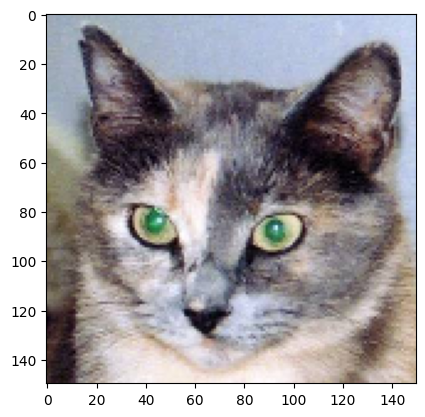

In [5]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps we want to look at, we will create a Keras model that takes batches of images as input, and outputs 
the activations of all convolution and pooling layers. To do this, we will use the Keras class `Model`. A `Model` is instantiated using two 
arguments: an input tensor (or list of input tensors), and an output tensor (or list of output tensors). The resulting class is a Keras 
model, just like the `Sequential` models that you are familiar with, mapping the specified inputs to the specified outputs. What sets the 
`Model` class apart is that it allows for models with multiple outputs, unlike `Sequential`. For more information about the `Model` class, see 
Chapter 7, Section 1.

In [6]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model. This is the first time you encounter 
a multi-output model in this book: until now the models you have seen only had exactly one input and one output. In the general case, a 
model could have any number of inputs and outputs. This one has one input and 8 outputs, one output per layer activation.

In [7]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 4s 4s/step


For instance, this is the activation of the first convolution layer for our cat image input:

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It's a 148x148 feature map with 32 channels. Let's try visualizing the 3rd channel:

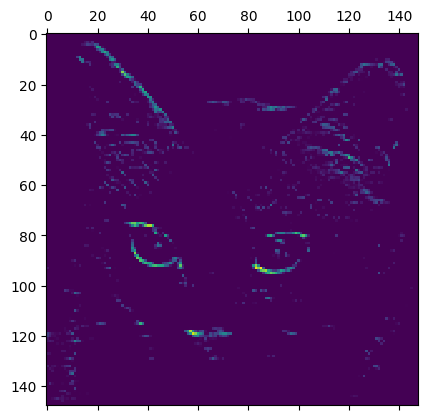

In [9]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

This channel appears to encode a diagonal edge detector. Let's try the 30th channel -- but note that your own channels may vary, since the 
specific filters learned by convolution layers are not deterministic.

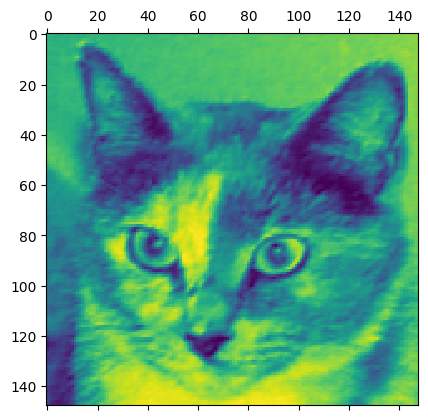

In [11]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

This one looks like a "bright green dot" detector, useful to encode cat eyes. At this point, let's go and plot a complete visualization of 
all the activations in the network. We'll extract and plot every channel in each of our 8 activation maps, and we will stack the results in 
one big image tensor, with channels stacked side by side.

C:\Users\Zoran\AppData\Local\Temp\ipykernel_2272\2282455063.py:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
C:\Users\Zoran\AppData\Local\Temp\ipykernel_2272\2282455063.py:33: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


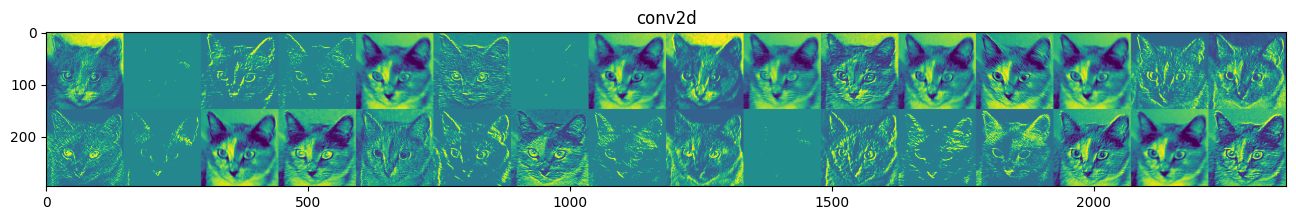

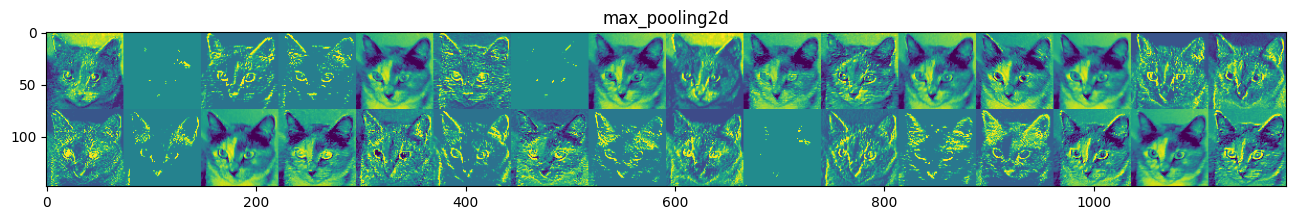

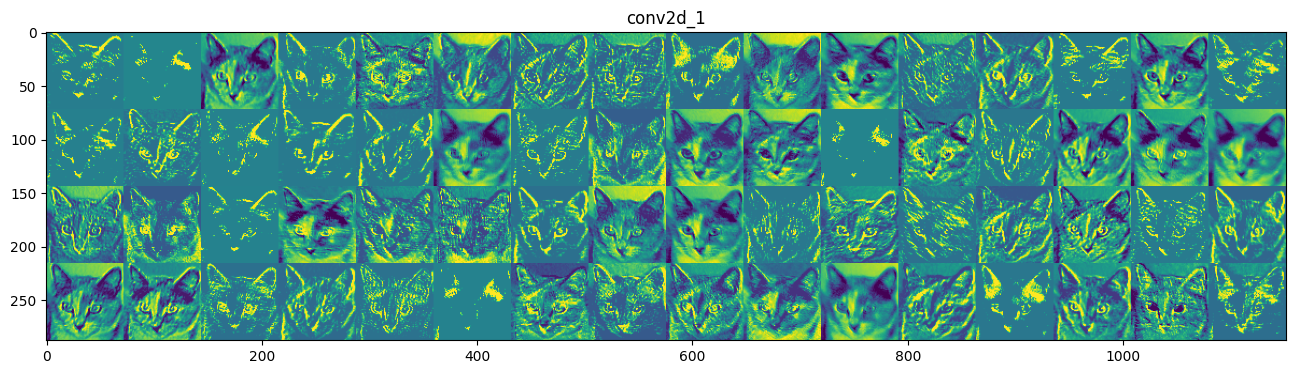

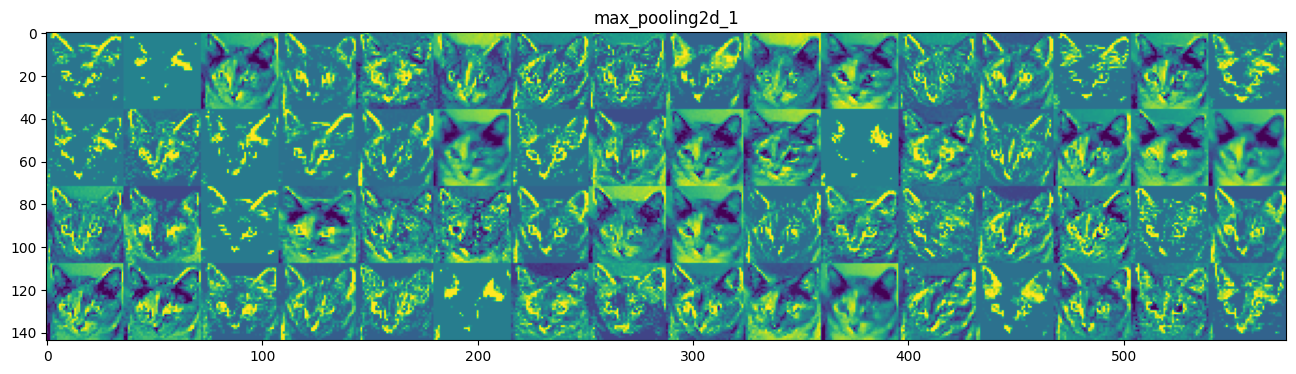

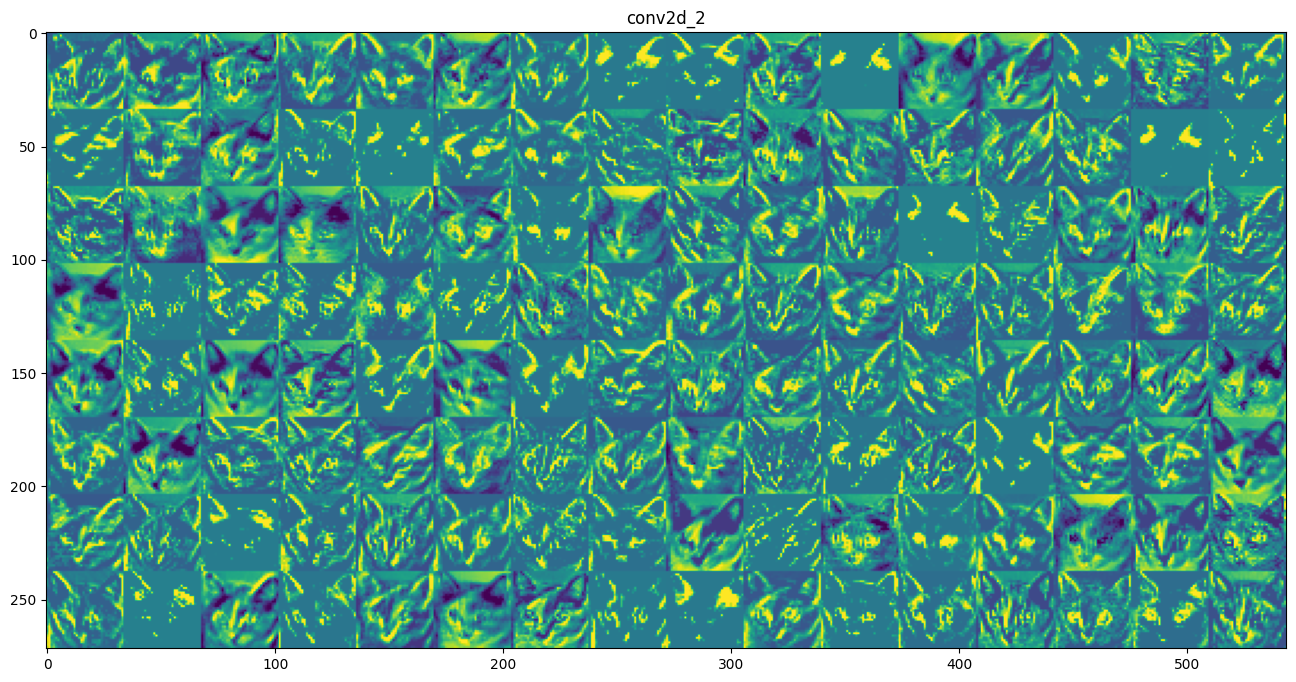

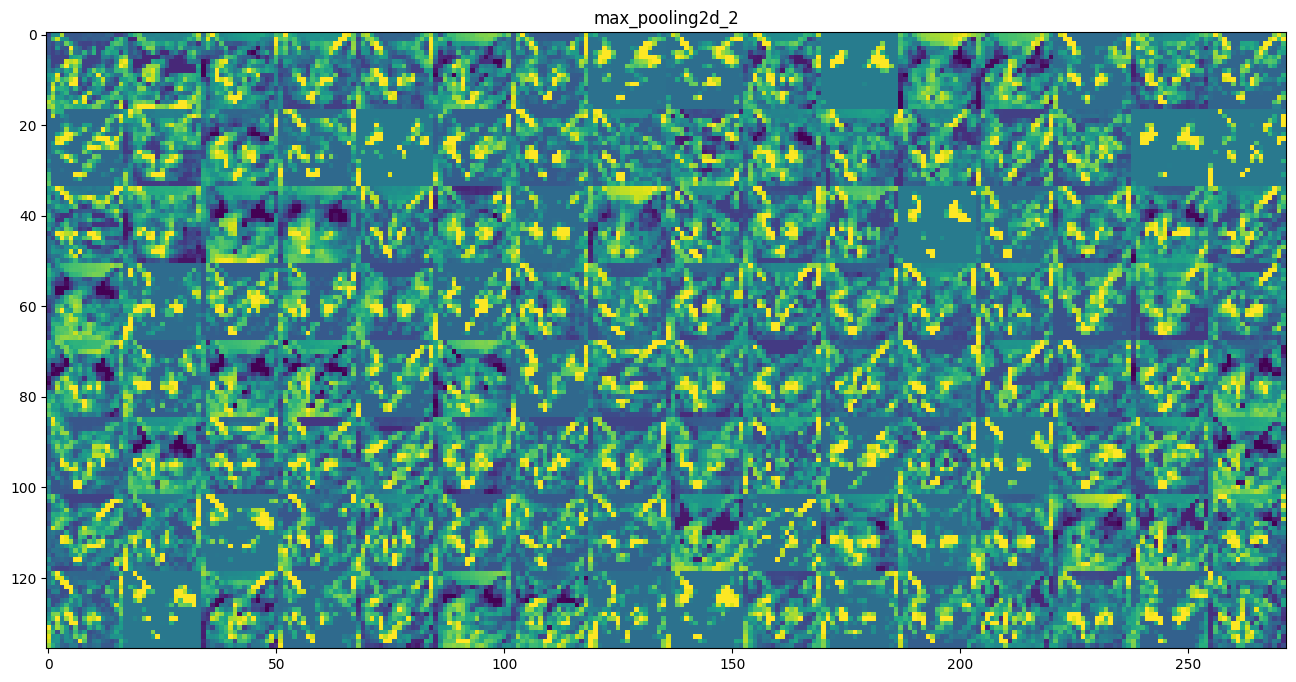

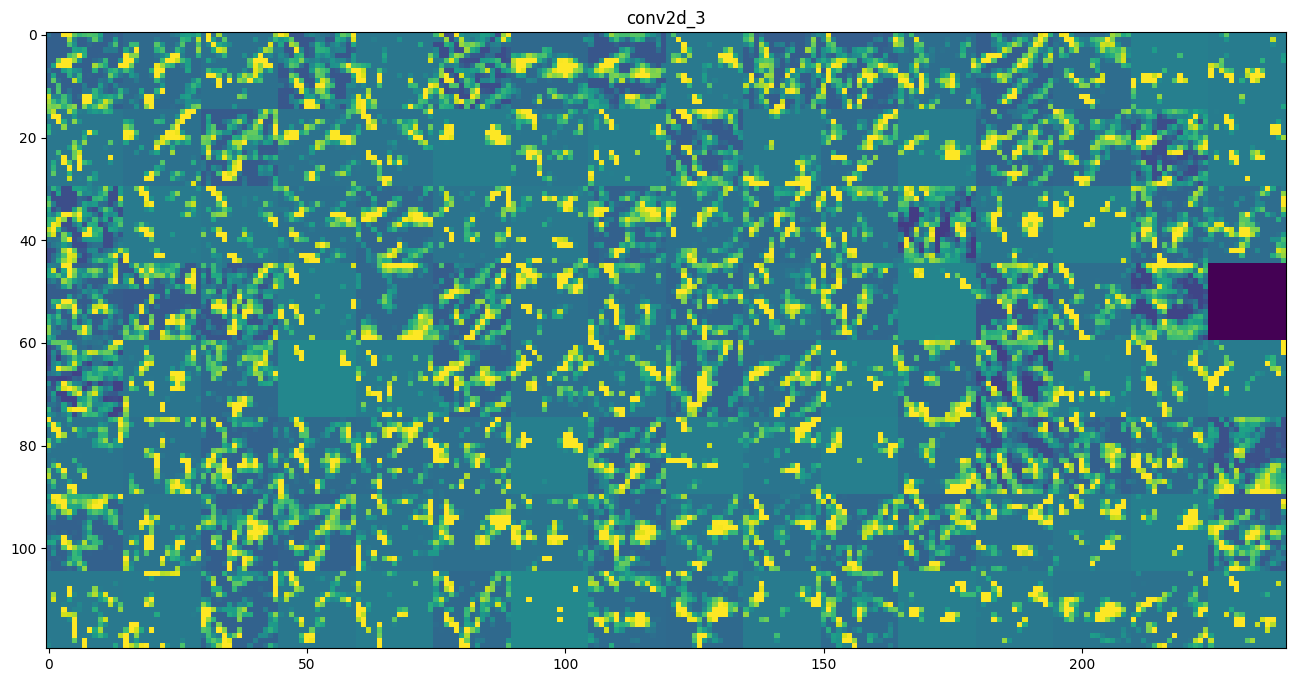

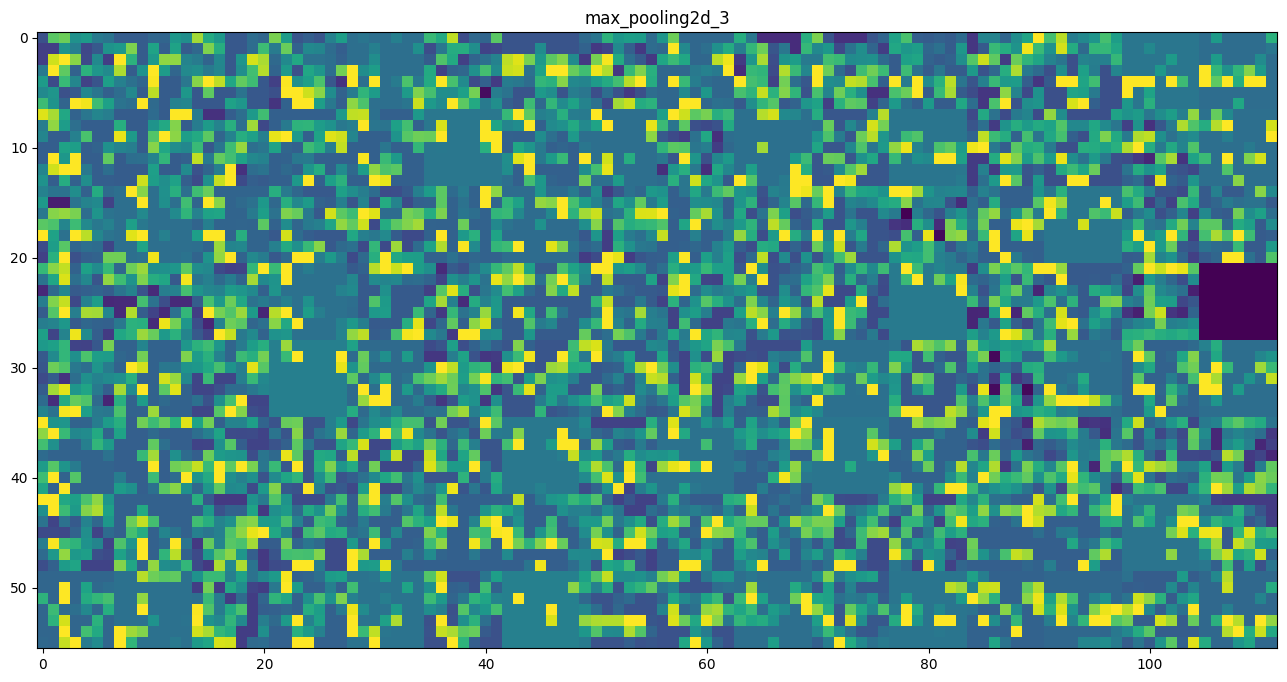

In [12]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

A few remarkable things to note here:

* The first layer acts as a collection of various edge detectors. At that stage, the activations are still retaining almost all of the 
information present in the initial picture.
* As we go higher-up, the activations become increasingly abstract and less visually interpretable. They start encoding higher-level 
concepts such as "cat ear" or "cat eye". Higher-up presentations carry increasingly less information about the visual contents of the 
image, and increasingly more information related to the class of the image.
* The sparsity of the activations is increasing with the depth of the layer: in the first layer, all filters are activated by the input 
image, but in the following layers more and more filters are blank. This means that the pattern encoded by the filter isn't found in the 
input image.


We have just evidenced a very important universal characteristic of the representations learned by deep neural networks: the features 
extracted by a layer get increasingly abstract with the depth of the layer. The activations of layers higher-up carry less and less 
information about the specific input being seen, and more and more information about the target (in our case, the class of the image: cat 
or dog). A deep neural network effectively acts as an __information distillation pipeline__, with raw data going in (in our case, RBG 
pictures), and getting repeatedly transformed so that irrelevant information gets filtered out (e.g. the specific visual appearance of the 
image) while useful information get magnified and refined (e.g. the class of the image).

This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which 
abstract objects were present in it (e.g. bicycle, tree) but could not remember the specific appearance of these objects. In fact, if you 
tried to draw a generic bicycle from mind right now, chances are you could not get it even remotely right, even though you have seen 
thousands of bicycles in your lifetime. Try it right now: this effect is absolutely real. You brain has learned to completely abstract its 
visual input, to transform it into high-level visual concepts while completely filtering out irrelevant visual details, making it 
tremendously difficult to remember how things around us actually look.

## Visualizing convnet filters


Another easy thing to do to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond 
to. This can be done with __gradient ascent in input space__: applying __gradient descent__ to the value of the input image of a convnet so 
as to maximize the response of a specific filter, starting from a blank input image. The resulting input image would be one that the chosen 
filter is maximally responsive to.

The process is simple: we will build a loss function that maximizes the value of a given filter in a given convolution layer, then we 
will use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. For instance, here's 
a loss for the activation of filter 0 in the layer "block3_conv1" of the VGG16 network, pre-trained on ImageNet:

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [13]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#### Graph of VGG16 Architecture
The above architecture is frequently presented with the following graph

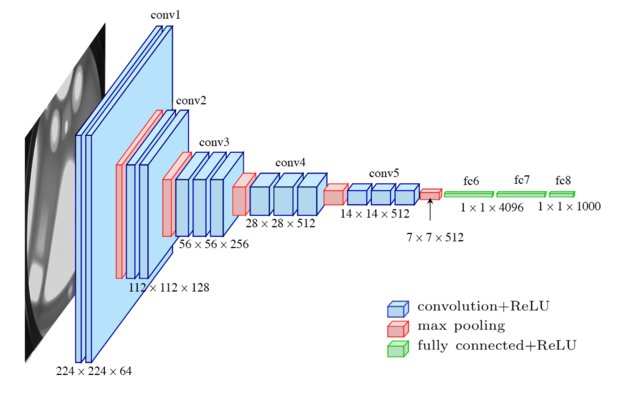